In [131]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.set_random_seed(683)
# Uncomment this to hide TF warnings about allocation
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian, frangi
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

In [133]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def frangi_me(X):
    return np.asarray([frangi(item) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [119]:
train = pd.read_json("../_RawData/train.json/data/processed/train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and 
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [134]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    
    if labeled:
        band_1_90_1 = np.rot90(band_1, k = 1, axes = (1, 2))
        band_1_90_2 = np.rot90(band_1, k = 2, axes = (1, 2))
        band_1_90_3 = np.rot90(band_1, k = 3, axes = (1, 2))

        band_1 = np.append(band_1, band_1_90_1, axis = 0)
        band_1 = np.append(band_1, band_1_90_2, axis = 0)
        band_1 = np.append(band_1, band_1_90_3, axis = 0)

        band_2_90_1 = np.rot90(band_2, k = 1, axes = (1, 2))
        band_2_90_2 = np.rot90(band_2, k = 2, axes = (1, 2))
        band_2_90_3 = np.rot90(band_2, k = 3, axes = (1, 2))

        band_2 = np.append(band_2, band_2_90_1, axis = 0)
        band_2 = np.append(band_2, band_2_90_2, axis = 0)
        band_2 = np.append(band_2, band_2_90_3, axis = 0)    

        band_3_90_1 = np.rot90(band_3, k = 1, axes = (1, 2))
        band_3_90_2 = np.rot90(band_3, k = 2, axes = (1, 2))
        band_3_90_3 = np.rot90(band_3, k = 3, axes = (1, 2))

        band_3 = np.append(band_3, band_3_90_1, axis = 0)
        band_3 = np.append(band_3, band_3_90_2, axis = 0)
        band_3 = np.append(band_3, band_3_90_3, axis = 0)
        
        images1 = np.append(images, np.rot90(images, k = 1, axes=(1, 2)), axis = 0)
        images2 = np.append(images1, np.rot90(images, k = 2, axes=(1, 2)), axis = 0)
        images = np.append(images2, np.rot90(images, k = 3, axes=(1, 2)), axis = 0)
    
# band_1_new.shape

    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = frangi_me(smooth(denoise(band_1, weight_gray, False), smooth_gray))
        print('Gray 1 done')
        band_2 = frangi_me(smooth(denoise(band_2, weight_gray, False), smooth_gray))
        print('Gray 2 done')
        band_3 = frangi_me(smooth(denoise(band_3, weight_gray, False), smooth_gray))
        print('Gray 3 done')
    if train_img and clean_img:
        images = frangi_me(smooth(denoise(images, weight_rgb, True), smooth_rgb))
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
        y = np.append(y, y)
        y = np.append(y, y)
    else:
        y = None
    return y, band, images

In [135]:
y_train, X_b, X_images = create_dataset(train, True)
print(y_train.shape)
print(X_b.shape)
print(X_images.shape)


Denoising and reshaping
RGB done
(6416,)
(6416, 75, 75, 3)
(6416, 75, 75, 3)


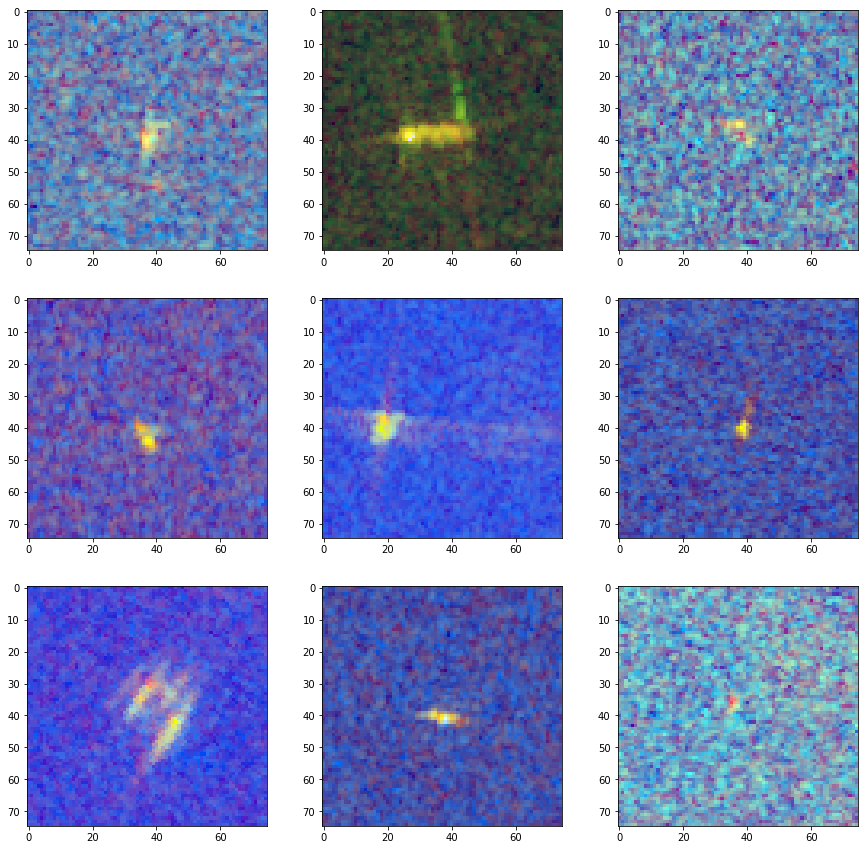

In [122]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

In [123]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

IndexError: index 4213 is out of bounds for axis 0 with size 1604

In [ ]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

In [ ]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

In [136]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [137]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [138]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [139]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [140]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [141]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=15,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [ ]:
train.head()

band_1, band_2, images = train['band_1'].values, train['band_2'].values, color_composite(train)
print(images.shape)
to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
band_1 = to_arr(band_1)
band_2 = to_arr(band_2)
band_3 = (band_1 + band_2) / 2
gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
# Make a picture format from flat vector
band_1 = gray_reshape(band_1)
band_2 = gray_reshape(band_2)
band_3 = gray_reshape(band_3)
# print('Denoising and reshaping')
# if train_b and clean_b:
#     # Smooth and denoise data
#     band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
#     print('Gray 1 done')
#     band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
#     print('Gray 2 done')
#     band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
#     print('Gray 3 done')
# if train_img and clean_img:
#     images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
# print('RGB done')
# tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
# band_1 = tf_reshape(band_1)
# band_2 = tf_reshape(band_2)
# band_3 = tf_reshape(band_3)
# #images = tf_reshape(images)
# band = np.concatenate([band_1, band_2, band_3], axis=3)
# if labeled:
#     y = np.array(frame["is_iceberg"])
# else:
#     y = None

In [ ]:
images.shape

In [ ]:
np.append(images, np.rot90(images, k = 1, axes=(1, 2)), axis = 0).shape

In [ ]:
# def augment(x):
#     print(x.shape)
#     return x
# #     return np.rot90(x, 1)

# # v_func = np.vectorize(augment)
# np.apply_along_axis(augment, [1, 2], band_1)
# # v_func(band_1).shape

# for item in band_1:
#     np.rot90(item, 1)
#     print(item.shape)

band_1_90_1 = np.rot90(band_1, k = 1, axes = (1, 2))
band_1_90_2 = np.rot90(band_1, k = 2, axes = (1, 2))
band_1_90_3 = np.rot90(band_1, k = 3, axes = (1, 2))

band_1_new = np.append(band_1, band_1_90_1, axis = 0)
band_1_new = np.append(band_1_new, band_1_90_2, axis = 0)
band_1_new = np.append(band_1_new, band_1_90_3, axis = 0)
band_1_new.shape

In [ ]:
print(band_1.shape)
print(band_1_90_1.shape)
print(band_1[0])
print(band_1_90_1[0])
print(band_1_90_2[0])
print(band_1_90_3[0])


In [ ]:
# np.concatenate((train['is_iceberg'].shape, train['is_iceberg'].shape), axis = 1)
y = np.array(train["is_iceberg"])
y = np.append(y, y)
y = np.append(y, y)


In [ ]:
y.shape

In [142]:
# Best parameters i got are
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 25, 1, return_model=True)

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training bandwidth network
Epoch 1/25
154/153 [==============================] - 9s 58ms/step - loss: 0.6192 - acc: 0.6280 - val_loss: 0.6059 - val_acc: 0.6724
Epoch 2/25
154/153 [==============================] - 6s 40ms/step - loss: 0.5152 - acc: 0.7389 - val_loss: 0.5072 - val_acc: 0.7497
Epoch 3/25
154/153 [==============================] - 6s 42ms/step - loss: 0.4536 - acc: 0.7890 - val_loss: 0.5159 - val_acc: 0.7682
Epoch 4/25
154/153 [==============================] - 7s 43ms/step - loss: 0.4184 - acc: 0.8000 - val_loss: 0.4344 - val_acc: 0.7982
Epoch 5/25
154/153 [==============================] - 7s 43ms/step - loss: 0.3894 - acc: 0.8204 - val_loss: 0.3916 - val_acc: 0.8328
Epoch 6/25
154/153 [==============================] - 7s 46ms/step - loss: 0.3777 - acc: 0.8179 - val_loss: 0.4134 - val_acc: 0.8108
Epoch 7/25
154/153 [==============================] - 7s 46ms/step - loss: 0.3665 - acc: 0.8326 - val_loss: 0.4118 - val_acc: 0.8051
Epoch 8/25
154/153 [======================

181/180 [==============================] - 16s 87ms/step - loss: 0.2098 - acc: 0.9105 - val_loss: 0.1610 - val_acc: 0.9159
Epoch 11/15
181/180 [==============================] - 16s 88ms/step - loss: 0.2106 - acc: 0.9093 - val_loss: 0.1497 - val_acc: 0.9439
Epoch 12/15
181/180 [==============================] - 17s 91ms/step - loss: 0.2020 - acc: 0.9145 - val_loss: 0.1481 - val_acc: 0.9377
Epoch 13/15
181/180 [==============================] - 16s 90ms/step - loss: 0.1943 - acc: 0.9160 - val_loss: 0.1616 - val_acc: 0.9315
Epoch 14/15
181/180 [==============================] - 16s 88ms/step - loss: 0.1955 - acc: 0.9177 - val_loss: 0.1633 - val_acc: 0.9377
Epoch 15/15
181/180 [==============================] - 16s 89ms/step - loss: 0.1946 - acc: 0.9210 - val_loss: 0.1569 - val_acc: 0.9346
Loss: 0.148089958129 Acc: 0.93769470405



181/180 [==============================] - 17s 94ms/step - loss: 0.2110 - acc: 0.9070 - val_loss: 0.1557 - val_acc: 0.9377

Loss: 0.154508060616 Acc: 0.928348909657

181/180 [==============================] - 16s 89ms/step - loss: 0.1946 - acc: 0.9210 - val_loss: 0.1569 - val_acc: 0.9346

Loss: 0.148089958129 Acc: 0.93769470405

In [143]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json("../_RawData/test.json/data/processed/test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    preds = np.clip(prediction.reshape((prediction.shape[0])), 0.0001, 0.9999)
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': preds})

    submission.to_csv("./submission2-augment2.csv", index=False)
    print('Done')

Reading test dataset
Denoising and reshaping
RGB done
Predicting
8424/8424 [==============================] - 6s 680us/step
Submitting
Done
